In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['nature','no-latex'])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from scipy.linalg import expm 

# Construyendo la ecuación maestra

## Construyendo el Hamiltoniano total
$H = H_{ground} \oplus H_{excited} \oplus H_{isc} $

donde:
\begin{align}
H_{ground} &= D_g(S_z^2 - \frac{2}{3}I) + E(S_x^2 - S_y^2) + \gamma \boldsymbol{B} \cdot \boldsymbol{S} \\
H_{excited} &= D_e(S_z^2 - \frac{2}{3}I) + E(S_x^2 - S_y^2) + \gamma \boldsymbol{B} \cdot \boldsymbol{S} \\
H_{isc} &= 0_{1x1}
\end{align}

Los valores 
\begin{align}
D_g &= 2.87 \; GHz & D_e &= 1.42 \; GHz \\
E &= 5 \;MHz & \gamma &= 28 \;GHz/T 
\end{align}

Los operadores de spin 1
\begin{align}
S_x &= \frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0& 1& 0 \end{pmatrix} &
S_y &= \frac{1}{\sqrt{2}}\begin{pmatrix} 0 & -i & 0 \\ i & 0 & -i \\ 0& i& 0 \end{pmatrix} &
S_z &= \begin{pmatrix} 1 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & -1 \end{pmatrix}
\end{align}

Usaremos una base de 7 niveles que se obtiene de los autoestados de $S_z\oplus S_z \oplus I_{1x1}$ 

\begin{align}
|g,+1\rangle = |0\rangle &= [1,0,0,0,0,0,0].T  & |g,0\rangle = |1\rangle  &= [0,1,0,0,0,0,0].T  &  |g,-1\rangle = |2\rangle  &= [0,0,1,0,0,0,0].T  \\
|e,+1\rangle = |3\rangle  &= [0,0,0,1,0,0,0].T  & |g,0\rangle = |4\rangle  &= [0,0,0,0,1,0,0].T  & |g,-1\rangle = |5\rangle  &= [0,0,0,0,0,1,0].T \\
|s\rangle = |6\rangle  &= [0,0,0,0,0,0,1].T
\end{align}

In [3]:
# Parametros 
D_g,D_e = 2.87,1.42 # en GHz
gamma = 28 # en GHz/T

# Definimos operadores spin S=1
S_x = 1/np.sqrt(2)*np.array([[0,1,0],[1,0,1],[0,1,0]])
S_y = 1/np.sqrt(2)*np.array([[0,-1j,0],[1j,0,-1j],[0,1j,0]])
S_z = np.array([[1,0,0],[0,0,0],[0,0,-1]])

# Definimos la base
dim = 7
base = np.eye(dim)

def Htotal(B = 1*10**(-3), theta = 10*(np.pi/180), phi = 0*(np.pi/180), E = 5*10**(-3)):
    
    # Campo magnetico
    B_x = B*np.sin(theta)*np.cos(phi)
    B_y = B*np.sin(theta)*np.sin(phi)
    B_z = B*np.cos(theta)
    
    # Hamiltoniano del estado base 
    H_ground = D_g*(S_z @ S_z - 2/3*np.eye(3)) + E*(S_x @ S_x - S_y @ S_y) + gamma*(B_x*S_x + B_y*S_y + B_z*S_z)
    H_excited = D_e*(S_z @ S_z - 2/3*np.eye(3)) + E*(S_x @ S_x - S_y @ S_y) + gamma*(B_x*S_x + B_y*S_y + B_z*S_z)
    H_isc = np.array([[0]]) 

    # Sumamos primero los 2 primeros hamiltonianos
    zeros = np.zeros( (len(H_ground),len(H_excited)) ) # arrays de ceros
    H_ground_excited = np.block([[H_ground,zeros],[zeros.T,H_excited]])

    zeros = np.zeros( (len(H_ground_excited),len(H_isc)) )
    H = np.block([[H_ground_excited,zeros],[zeros.T,H_isc]])
    return H

## Calculando la matriz de cambio de base 

Cuando un campo magnetico estatico $\boldsymbol{B}$ es aplicado al defecto NV, los 7 autoestados del centro NV $\{|i\rangle$ puede ser expresado como una combinación lineal de los autoestados con campo cero 
$$
|i\rangle = \sum_{j=0}^7 U_{ij}(\boldsymbol{B}) \; |j\rangle_0
$$

Los terminos $U_{ij}(\boldsymbol{B})$ son los elementos de la matriz de cambio de base $U$ y son computados numericamente usando las expresiones de $\mathcal{H}_{ground}$ , $\mathcal{H}_{excited}$ y $|6\rangle = |6\rangle_0$. 

In [4]:
def Base_nueva(B = 1*10**(-3), theta = 10*(np.pi/180), phi = 0*(np.pi/180), E = 5*10**(-3)):
    
    # Campo magnetico
    
    B_x = B*np.sin(theta)*np.cos(phi)
    B_y = B*np.sin(theta)*np.sin(phi)
    B_z = B*np.cos(theta)
    
    # Hamiltoniano del estado base 
    H_ground = D_g*(S_z @ S_z - 2/3*np.eye(3)) + E*(S_x @ S_x - S_y @ S_y) + gamma*(B_x*S_x + B_y*S_y + B_z*S_z)
    H_excited = D_e*(S_z @ S_z - 2/3*np.eye(3)) + E*(S_x @ S_x - S_y @ S_y) + gamma*(B_x*S_x + B_y*S_y + B_z*S_z)
    H_isc = np.array([[0]]) 
    
    ######## Para el estado base ###########
    # Los nuevos autoestados 
    autovalores, autovectores = np.linalg.eig(H_ground)   
    indices_ordenados = np.argsort(autovalores)
    autovectores_ordenados_ground = autovectores[:, indices_ordenados].T  # Usamos la transpuesta
            
    ######## Para el estado excited ###########
    # Los nuevos autoestados 
    autovalores, autovectores = np.linalg.eig(H_excited)   
    indices_ordenados = np.argsort(autovalores)
    autovectores_ordenados_excited = autovectores[:, indices_ordenados].T  # Usamos la transpuesta
    
    # Sumamos primero los 2 primeros hamiltonianos
    zeros = np.zeros( (len(autovectores_ordenados_ground),len(autovectores_ordenados_excited)) ) # arrays de ceros
    matriz_ground_excited = np.block([[autovectores_ordenados_ground,zeros],[zeros.T,autovectores_ordenados_excited]])

    ket7 = np.array([[1]])
    zeros = np.zeros( (len(matriz_ground_excited),len(ket7)) )
    base_nueva = np.block([[matriz_ground_excited,zeros],[zeros.T,ket7]])
    
    return base_nueva

## Construyendo los operadores de lindblad
Los Operadores de Lindblad son 
\begin{equation}
L_{ij} = \sqrt{R_{ij}}|j\rangle \langle i| 
\end{equation}

donde $R_{ij}$ es la taza de transición del estado $|i\rangle$ al estado $|j\rangle$. Se define la matriz de transición

$$ R = \begin{pmatrix} 0 & 0 & 0 & k\gamma_{eg} & 0 & 0 & 0 \\
                       0 & 0 & 0 & 0 & k \gamma_{eg} & 0 & 0  \\
                       0 & 0 & 0 & 0 & 0 &  \gamma_{eg} & 0 \\
                       \gamma_{eg} & 0 & 0 & 0 & 0  & 0 & \gamma_{36} \\
                       0 & \gamma_{eg} & 0 & 0 & 0 & 0 & \gamma_{46} \\
                       0 & 0 & \gamma_{eg} & 0 & 0 & 0 & \gamma_{56} \\
                       \gamma_{60} & \gamma_{61} & \gamma_{62} & 0 & 0 & 0 & 0 
        \end{pmatrix}
$$

"k" es el parametro que depende de la potencia del laser. Y los parametros experimentales restantes (que falta justificar Tietene) son
\begin{align}
    \gamma_{eg} &= 65.9 \; MHz & \gamma_{36} = \gamma_{56} &= 53.3\; MHz & \gamma_{46} &= 7.9 \; MHz \\
    k &\in [0,1] & \gamma_{60} = \gamma_{62} &= 0.73 \; MHz & \gamma_{61} &= 0.98 \; MHz
\end{align}


--------------------------------------------------------------------------------------------------------------

Las nuevas transiciones $\{\mathcal{R}_{ij}(\boldsymbol{B})\}$ son relacionado a las transiciones de campo cero $\{\mathcal{R}_{ij}^{0}\}$ a travez de la siguiente transformación (esta justificada en la imagen posterior) 

(Adjuntar imagen para justificar la ecuación ////// pendiente)

$$
\mathcal{R}_{ij}(\boldsymbol{B}) = \sum_{p=0}^{6}\sum_{q=0}^6 = |U_{ip}|^2 \;\mathcal{R}_{pq}^{0}\; |U_{jq}|^2 \quad \Longleftrightarrow \quad \mathcal{R} = U_2 \; \mathcal{R}^{0} \; U_2^{T}
$$

donde $U_2$ es la matriz cuyos elementos son el cuadrado de los elementos de la matriz cambio de base U:

$$ [U_2]_{ij} = |U_{ij}|^2 $$

-------------------------------------------------------------------------------------------------------------

Algunas sugerencias son las siguientes: 
- Ordena los elementos $|i\rangle$ de menor a mayor energia para mantener un orden en la solución de la ecuación de tasas

\begin{align}
E(|0\rangle) &< E(|1\rangle) < E(|2\rangle) \\
E(|3\rangle) &< E(|4\rangle) < E(|5\rangle)
\end{align}

- La matriz de cambio de base $U$ hallalá en calculo separado de autoestados $\mathcal{H}_{ground}$ y $\mathcal{H}_{excited}$ y no lo juntes en un solo Hamiltoniano. Ademas la matriz $U$ tiene la siguiente forma 

$$
U = \begin{bmatrix} & [(|0\rangle )]_{1x3}&  & 0 & 0 & 0 & 0   \\
                    & [(|1\rangle )]_{1x3}&  & 0 & 0 & 0 & 0   \\
                    & [(|2\rangle )]_{1x3}&  & 0 & 0 & 0 & 0   \\
                     0 & 0 & 0 & & [(|3\rangle )]_{1x3}& & 0   \\
                      0 & 0 & 0 & & [(|4\rangle )]_{1x3}& & 0   \\
                       0 & 0 & 0 & & [(|5\rangle )]_{1x3}& & 0   \\ 
                       0 & 0 & 0 & 0 & 0 & 0 & [(|6\rangle )]_{1x1} \end{bmatrix}
$$


In [5]:
###### Valores de Tietenne
gamma_eg = 65.9*10**(-3)  # Lo pasamos a GHz
gamma_36 = gamma_56 = 53.3*10**(-3) 
gamma_46 = 7.9*10**(-3)
k = 0.3 # este valor se puede cambiar 
gamma_60 = gamma_62 = 0.73*10**(-3) 
gamma_61 = 0.98*10**(-3)

#########################################
gamma_eg = 65.9*10**(-3)  # No lo borres
'''
Si transformación -- > True entonces se hace una transformación de los nuevos operadores de Lindblad con la nueva base
Si transformación -- > False entonces se deja y se forma los operadores de Lindblad de manera sencilla
'''
def operadores_lindblad(gamma_eg=65.9*10**(-3), gamma_3656 = 53.3*10**(-3) ,gamma_46 = 7.9*10**(-3),
                      k = 0.03,gamma_6062 = 0.73*10**(-3) , gamma_61 = 0.98*10**(-3),transformacion = False,base_nueva=0):
    
    gamma_36 = gamma_56 = gamma_3656
    gamma_60 = gamma_62 = gamma_6062
    # Matriz rate
    R = np.array([[0,0,0,k*gamma_eg,0,0,0],
                  [0,0,0,0,k*gamma_eg,0,0],
                  [0,0,0,0,0,k*gamma_eg,0],
                  [gamma_eg,0,0,0,0,0,gamma_36],
                  [0,gamma_eg,0,0,0,0,gamma_46],
                  [0,0,gamma_eg,0,0,0,gamma_56],
                  [gamma_60,gamma_61,gamma_62,0,0,0,0]])
    
    base1 = base
    if transformacion == True:
        base1 = base_nueva
        U2 = base_nueva*base_nueva.conjugate()
        R = U2 @ R @ U2.T 
    
    Ls = [] # lista de operadores de Lindblad 
    for i in range(dim):
        for j in range(dim):
            Ls.append( np.sqrt(R[i,j])*np.outer(base1[j],base1[i].conjugate()) )
    
    return Ls

## Ecuación de Lindblad
Tenemos que resolver la dinamica del sistema con la ecuación de Lindblad 
$$
\frac{\rho(t)}{dt} = -\frac{i}{\hbar}[\mathcal{H},\rho] + \sum_{a}L_a \rho L_{a}^{\dagger} - \frac{1}{2}\sum_{a}(L_a^{\dagger}L_a \rho + \rho L_a^{\dagger}L_a) 
$$

Aqui la suma sobre ''a'' recorre todos los operadores de Lindblad 

## Construyento del superoperador Liouville (Liouvillian)
Es conveniente expresar la ecuación maestra en notación vectorial
$$
\boldsymbol{\dot{\rho}} = \mathcal{L}\boldsymbol{\rho}
$$
donde $\boldsymbol{\rho} = \text{vec}(\rho)$ y $\mathcal{L}$ tiene la expresión siguiente
$$
\mathcal{L} = -\frac{i}{\hbar}(I\otimes H - H^{T} \otimes I) + \sum_a L_a^{*} \otimes L_a -\frac{1}{2}(I\otimes L_{a}^{\dagger}L_a + L_a^{T}L_{a}^{*} \otimes I)
$$

In [6]:
# construyend el superoperador del hamltoniano 
# El conjunto de operadores de lindblad se reescala por la raiz de las tasas
def Liouvillian(H, Ls, hbar =1):
    d = len(H) # dimension del sistema
    superH = -1j/hbar * (np.kron(np.eye(d),H) - np.kron(H.T,np.eye(d)) ) # Parte Hamiltoniana 
    superL = sum([np.kron(L.conjugate(),L)
                 -1/2 * (np.kron(np.eye(d),L.conjugate().T.dot(L)) + 
                        np.kron(L.T.dot(L.conjugate()),np.eye(d))
                        ) for L in Ls]) # es un elegante codigo
    return superH + superL 

## Fluorescencia PL y poblaciones 
La fluorescencia se define 
$$
\Gamma_{PL} = \gamma_{eg}\text{Tr}[P_e \rho(t)]  
$$ 
donde
$$
P_e = |e,+1\rangle \langle e,+1| + |e,0\rangle \langle e,0| + |e,-1\rangle \langle e,-1|\\
P_e = |3\rangle \langle 3| + |4\rangle \langle 4| + |5\rangle \langle 5|
$$

Y las poblaciones 
$$P_{|i\rangle} = \text{Tr}[ |i\rangle \langle i| \rho(t)]$$


In [7]:
########## Fluorescencia ###################
def PL(gamma_eg= 65.9*10**(-3),rho=np.eye(dim)):
    Pe = np.outer(base[3],base[3].conjugate()) + np.outer(base[4],base[4].conjugate()) + np.outer(base[5],base[5].conjugate()) 
    return gamma_eg*np.trace(Pe @ rho)

######### Población i ######################
def Poblacion(estadoi = 3, rho=np.eye(dim)):
    return np.real(np.trace( np.outer(base[estadoi],base[estadoi].conjugate()) @ rho))

# Solución de la ecuación maestra
## Solución del estado estable $\rho(\infty)$:  

Expresado la ecuación linear maestra en una forma de superoperador. Para encontrar el estado estable resolvemos el espacio nulo de $\mathcal{L}$

$$
\mathcal{L}\boldsymbol{\rho} = 0
$$
- Si hay una solución unica para el subespacio del espacio nulo, este corresponderá a un estado estable de la matriz denisdad $\rho(\infty)$ hasta un factor constante que esta dado por la condición $\text{Tr}(\rho) = 1$
- Si hay soluciones multiples, resolver el espacio nulo dará vectores linealmente independiente. En tal caso, el estado estable depende del estado inicial del sistema $\rho(0)$ (**Estoy confiando en mis calculos que este caso no se da XD )**

## Solución del estado dinámico $\rho(t)$ con $\mathcal{L}$ independiente del tiempo:

Sea la condición inicial $\rho_0 = \rho(t_0)$. Representamos la solución con  un mapeo dinamico $\rho(t) = \Lambda(t;t_0)\rho(t_0)$. Entonces la solución de la ecuación de lindblad en forma de superoperador esta dada por 
$$
\boldsymbol{\rho}(t) = \text{exp}[\mathcal{L}(t-t_0)]\boldsymbol{\rho}(t_0)
$$

El operador $\Lambda(t;t_0) = \text{exp}[\mathcal{L}(t-t_0)]$ es llamado el propagador de evolución

## Solución del estado dinámico $\rho(t)$ con $\mathcal{L}$ dependiente del tiempo:

En este caso se tiene
$$
\dot{\boldsymbol{\rho}(t)} = \mathcal{L}(t)\boldsymbol{\rho}
$$
En este caso la soluciión esta dado
$$
\boldsymbol{\rho}(t) = \mathcal{T}\left\{\text{exp}\left[\int_0^{t}\;ds\;\mathcal{L}(s)\right]\right\}\boldsymbol{\rho}(t_0)
$$

donde $\mathcal{T}$ es el operador de tiempo ordenado, analogo a la serie de Dyson para el Hamiltoniano dependiente del tiempo y la propagación de la función de onda.


In [8]:
# Propagación usando exmp de scipy
# Esta función es util para el caso 2
def Propagate(rho0, superop,t):
    d = len(rho0) # dimensión del sistema
    propagador = expm(superop*t) # 
    vec_rho_t = propagador @ np.reshape(rho0, (d**2,1)) # aplicar al estado inicial
    return np.reshape(vec_rho_t, (d,d))

# Estudio de la dinamica de centro NV con la ecuación maestra

## Poblaciones en función del tiempo / PL en función del tiempo (Dínamica de poblaciones)
Calcularemos las poblaciones : $P_{|i\rangle} = \text{Tr}[ |i\rangle \langle i| \rho(t)] \quad i = \{0,1,2,3,4,5,6\}$ en el tiempo

Calcularemos $\Gamma_{PL} = \gamma_{eg}\text{Tr}[P_e \rho(t)]$ donde $P_e = |3\rangle \langle 3| + |4\rangle \langle 4| + |5\rangle \langle 5|$

1. El estado inicial del sistema es del equilibrio de boltzam a temperatura ambiente $\rho(t=0) \; \alpha \; e^{-\beta H}$ 
2. Un pulso laser de duración $9 \mu s$ es aplicado a $1 \mu s$ $(k = 0.03)$ 
3. A los $10 \mu s$ el pulso laser se apaga $(k = 0)$

C:\Users\JAAL_\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


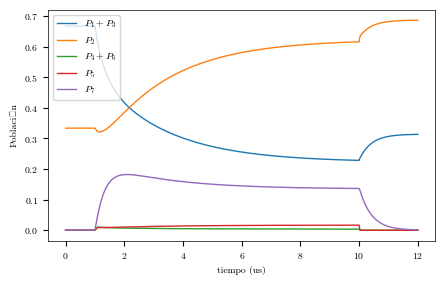

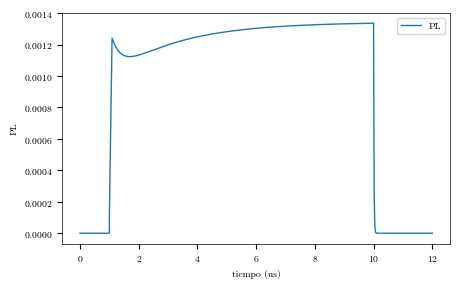

In [9]:
# Pasos en el tiempo
poblacion0, poblacion1,poblacion2,poblacion3, poblacion4, poblacion5, poblacion6 = [],[],[],[],[],[],[] # poblaciones
PL = [] # fluorescencia

# La condición inicial (distribución de boltzamn)
rho0 = np.zeros((dim,dim))
# rho0[1,1] = 0.7 # polarización en estado base
# rho0[0,0] = rho0[2,2]  = 0.3/2 ### condición de polarización en estado excitado
rho0[0,0] = rho0[1,1] = rho0[2,2] = 1/3

# Campo magnetico, valor de angulo longitudinal y azimutal
Bvalor = 50*10**(-3) # Valor de 50 mT para comprobar lo de Hincks
thetavalor = 0*(np.pi/180)
phivalor = 0*(np.pi/180)

################# El 1 us #############################################
times1 = np.linspace(0,1,10) # Para que no tome el ultimo valor
rho1 = 0 # sera utilizado como condicion inicial para el siguiente
for time in times1:
    Hvalor = np.zeros((dim,dim))# Hamiltoniano /// No hay Hamiltoniano aqui 
    Lsvalores = [] # Pasamos una lista vacia /// No hay evolución no unitaria
    # superoperador
    superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
    rho1 = Propagate(rho0 = rho0 ,superop = superoperador,t = (time-0)*10**(3)) # propagamos
    #### guardamos las poblaciones
    poblacion0.append(Poblacion(estadoi = 0, rho=rho1) + Poblacion(estadoi = 2, rho=rho1)) # Pob0 + Pob2
    poblacion1.append(Poblacion(estadoi = 1, rho=rho1)) # Pob1
    #poblacion2.append(Poblacion(estadoi = 2, rho=rho1)) # Pob2 
    poblacion3.append(Poblacion(estadoi = 3, rho=rho1) + Poblacion(estadoi = 5, rho=rho1)) # Pob3 + Pob5
    poblacion4.append(Poblacion(estadoi = 4, rho=rho1)) # pob4
    # poblacion5.append(Poblacion(estadoi = 5, rho=rho1)) # Pob5
    poblacion6.append(Poblacion(estadoi = 6, rho=rho1)) # Pob6
    
    # Guardamos en fluorescencia
    PL.append( gamma_eg*(Poblacion(estadoi = 3, rho=rho1) + Poblacion(estadoi = 4, rho=rho1) \
                            + Poblacion(estadoi = 5, rho=rho1) ) )
    
################## Se activa el laser (k != 0) de 1-10 us ##########################
times2 = np.linspace(1.001,10,100) 
rho2 = 0 # sera utilizado como condicion inicial para el siguiente
for time in times2:
    Hvalor = Htotal(B = Bvalor , theta = thetavalor , phi = phivalor , E = 5*10**(-3)) # Hamiltoniano
    base_nueva_valor = Base_nueva(B = Bvalor , theta = thetavalor , phi = phivalor , E = 5*10**(-3))
    Lsvalores = operadores_lindblad(transformacion=False,base_nueva=base_nueva_valor,k=0.03) # usamos los valores por defecto   
    # superoperador
    superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
    # Ese 10**(3) es para pasar a nanosegundos, necesario ya que yo trabajo en GHz
    rho2 = Propagate(rho0 = rho1 ,superop = superoperador,t = (time-1)*10**(3)) # propagamos
    # guardamos las poblaciones
    poblacion0.append(Poblacion(estadoi = 0, rho=rho2)+ Poblacion(estadoi = 2, rho=rho2)) # Pob0 + Pob2
    poblacion1.append(Poblacion(estadoi = 1, rho=rho2)) # Pob1
    # poblacion2.append(Poblacion(estadoi = 2, rho=rho2)) # Pob2 
    poblacion3.append(Poblacion(estadoi = 3, rho=rho2) + Poblacion(estadoi = 5, rho=rho2)) # Pob3 + Pob5
    poblacion4.append(Poblacion(estadoi = 4, rho=rho2)) # Pob4
    # poblacion5.append(Poblacion(estadoi = 5, rho=rho2)) # Pob5
    poblacion6.append(Poblacion(estadoi = 6, rho=rho2)) # Pob6
    
    # Guardamos en fluorescencia
    PL.append( gamma_eg*(Poblacion(estadoi = 3, rho=rho2) + Poblacion(estadoi = 4, rho=rho2) \
                            + Poblacion(estadoi = 5, rho=rho2) ) )

################ Se apaga el laser (k !=0) a los 10 us hasta el final ##################
times3 = np.linspace(10.001,12,100) 
rho3 = 0 # sera utilizado como condicion inicial para el siguiente
for time in times3:
    Hvalor = Htotal(B = Bvalor , theta = thetavalor , phi = phivalor , E = 5*10**(-3)) # Hamiltoniano
    base_nueva_valor = Base_nueva(B = Bvalor , theta = thetavalor , phi = phivalor , E = 5*10**(-3))
    Lsvalores = operadores_lindblad(transformacion=False,base_nueva=base_nueva_valor,k=0) # usamos los valores por defecto    
    # superoperador
    superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
    # Ese 10**(3) es para pasar a nanosegundos, necesario ya que yo trbajo en GHz
    rho3 = Propagate(rho0 = rho2 ,superop = superoperador,t = (time-10)*10**(3)) # propagamos
    # guardamos las poblaciones
    poblacion0.append(Poblacion(estadoi = 0, rho=rho3)+ Poblacion(estadoi = 2, rho=rho3)) # Pob0 + Pob2
    poblacion1.append(Poblacion(estadoi = 1, rho=rho3)) # Pob1
    # poblacion2.append(Poblacion(estadoi = 2, rho=rho3)) # Pob2 
    poblacion3.append(Poblacion(estadoi = 3, rho=rho3) + Poblacion(estadoi = 5, rho=rho3)) # Pob3 + Pob5
    poblacion4.append(Poblacion(estadoi = 4, rho=rho3)) # Pob4
    # poblacion5.append(Poblacion(estadoi = 5, rho=rho3)) # Pob5
    poblacion6.append(Poblacion(estadoi = 6, rho=rho3)) # Pob6
    
    # Guardamos en fluorescencia
    PL.append( gamma_eg*(Poblacion(estadoi = 3, rho=rho3) + Poblacion(estadoi = 4, rho=rho3) \
                            + Poblacion(estadoi = 5, rho=rho3) ) )

    
################### Grafica de poblaciones #####################################

plt.figure(figsize=(5, 3))    
plt.plot(list(times1) + list(times2) + list(times3),poblacion0, label = r"$P_1 + P_3$") 
plt.plot(list(times1) + list(times2)+ list(times3),poblacion1 , label = r"$P_2$") 
plt.plot(list(times1) + list(times2)+ list(times3),poblacion3, label = r"$P_4 + P_6$") 
plt.plot(list(times1) + list(times2)+ list(times3),poblacion4, label = r"$P_5$")
plt.plot(list(times1) + list(times2)+ list(times3),poblacion6, label = r"$P_7$")
plt.ylabel(r'Población')
plt.xlabel('tiempo (us)')
# plt.title('Fig-2.5')
plt.legend()
#plt.grid()
plt.show()


################### Grafica Fluorescencia #################################3

plt.figure(figsize=(5, 3))  
plt.plot(list(times1) + list(times2)+ list(times3),PL, label = r"PL")
plt.ylabel(r'PL')
plt.xlabel('tiempo (us)')
# plt.title('Fig-2.5')
plt.legend()
# plt.grid()
plt.show()

## PL de equilibrio vs potencia del laser (k) (Saturación de fluorescencia)

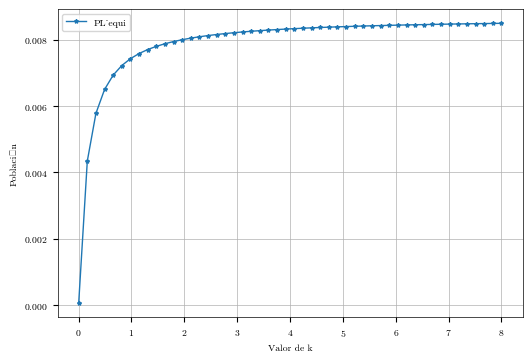

In [10]:
dim = 7
karray = np.linspace(0.001,8,50)
PL = []

# Campo magnetico, valor de angulo longitudinal y azimutal
Bvalor = 50*10**(-3) # Valor de 50 mT para comprobar lo de Hincks
thetavalor = 0*(np.pi/180)
phivalor = 0*(np.pi/180)

for k_valor in karray:
    # definimos
    Hvalor = Htotal(B = Bvalor , theta = thetavalor, phi = phivalor, E = 5*10**(-3))
    base_nueva_valor = Base_nueva(B = Bvalor , theta = thetavalor, phi = phivalor, E = 5*10**(-3))
    Lsvalores = operadores_lindblad(transformacion=False,base_nueva=base_nueva_valor,k=k_valor) # usamos los valores por defecto   
    
    # superoperador
    superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
    # null-space / usamos una función de scipy / y guardamos en un estado
    null = null_space(superoperador)
    rho_ss = np.reshape(null, (dim,dim) )
    rho_ss = rho_ss/np.trace(rho_ss)
    PL.append(gamma_eg*(Poblacion(estadoi = 3, rho=rho_ss) + Poblacion(estadoi = 4, rho=rho_ss) \
                            + Poblacion(estadoi = 5, rho=rho_ss) ) )

plt.figure(figsize=(6, 4)) 
plt.plot(karray,PL,'*-', label = r"PL_equi") 
plt.ylabel(r'Población')
plt.xlabel('Valor de k')
# plt.title('Fig-2.5')
plt.grid()
plt.legend()

plt.show()

## Poblaciones de equilibrio vs modulo de campo magnetico / ($\theta \neq 0$)
- En este caso sabemos que hay un estado de equilibrio y no depende de la condición inicial

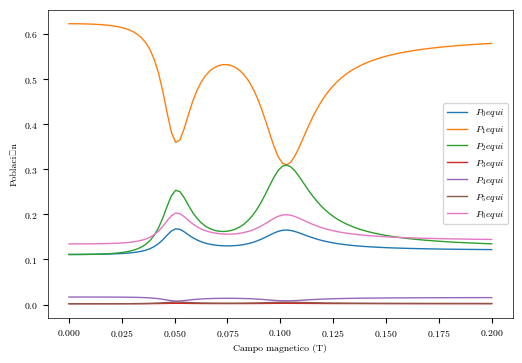

In [11]:
dim = 7
Barray = np.linspace(0,200*10**(-3),100)
poblacion0, poblacion1,poblacion2,poblacion3, poblacion4, poblacion5, poblacion6 = [],[],[],[],[],[],[]
PL = []


########################################################################################################################



for i,Bvalor in enumerate(Barray):
    # definimos
    Hvalor = Htotal(B = Bvalor, theta =  3*(np.pi/180), phi = 0*(np.pi/180), E = 5*10**(-3))
    base_nueva_valor = Base_nueva(B = Bvalor, theta = 3*(np.pi/180), phi = 0*(np.pi/180), E = 5*10**(-3))
    Lsvalores = operadores_lindblad(transformacion=False,base_nueva=base_nueva_valor,k=0.03) # usamos los valores por defecto   
    
    # superoperador
    superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
    # null-space / usamos una función de scipy / y guardamos en un estado
    null = null_space(superoperador)
    rho_ss = np.reshape(null, (dim,dim) )
    rho_ss = rho_ss/np.trace(rho_ss)
    # Población de equilibrio y agregamos a lista
    poblacion0.append(Poblacion(estadoi = 0, rho=rho_ss))
    poblacion1.append(Poblacion(estadoi = 1, rho=rho_ss))
    poblacion2.append(Poblacion(estadoi = 2, rho=rho_ss))
    poblacion3.append(Poblacion(estadoi = 3, rho=rho_ss))
    poblacion4.append(Poblacion(estadoi = 4, rho=rho_ss))
    poblacion5.append(Poblacion(estadoi = 5, rho=rho_ss))
    poblacion6.append(Poblacion(estadoi = 6, rho=rho_ss))
    
    PL.append(gamma_eg*( Poblacion(estadoi = 3, rho=rho_ss) + Poblacion(estadoi = 4, rho=rho_ss) \
                            + Poblacion(estadoi = 5, rho=rho_ss) ) )

plt.figure(figsize=(6, 4)) 
plt.plot(Barray,poblacion0, label = r"$P_0 equi$") 
plt.plot(Barray,poblacion1, label = r"$P_1 equi$") 
plt.plot(Barray,poblacion2, label = r"$P_2 equi$") 
plt.plot(Barray,poblacion3, label = r"$P_3 equi$") 
plt.plot(Barray,poblacion4, label = r"$P_4 equi$") 
plt.plot(Barray,poblacion5, label = r"$P_5 equi$") 
plt.plot(Barray,poblacion6, label = r"$P_6 equi$")
plt.ylabel(r'Población')
plt.xlabel('Campo magnetico (T)')
# plt.title('Fig-2.5')
plt.legend()

plt.show()

#################################################################################################################

## Mapa de calor de PL de equilibrio Con $(B_{\perp}, B_{z})$


El eje x tiene 100 valores
El eje y tine 100 valores


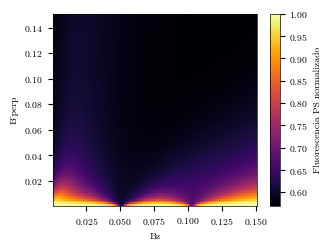

In [12]:
Y = np.linspace(1*10**(-3),150*10**(-3),100)
X = np.linspace(1*10**(-3),150*10**(-3),100) # tiene que ser maximo 100 porque despues de ese valor ocurre un intercruce 
                                    # y alli mi analisis carece de sentido

B_evalz, B_eval_perp = np.meshgrid(X, Y)   
ejey, ejex = B_evalz.shape # extraemos la longitud del eje x y eje y
print(f"El eje x tiene {ejex} valores")
print(f"El eje y tine {ejey} valores")

# Definimos la matriz donde guardaremos los datos de fluorescencia
PL = np.zeros((ejey, ejex)) # populación de \ket{0} asociado al autovalor menor

# calculamos autovectores 
for j in np.arange(0,ejex):
    for i in np.arange(0,ejey):
        # Variables 
        Bevalz = B_evalz[i,j]
        theta_val = np.arctan(B_eval_perp[i,j]/B_evalz[i,j])
        phi_val = 0
        Beval = (Bevalz**2 + B_eval_perp[i,j]**2)**0.5
        
        # definimos
        Hvalor = Htotal(B = Beval, theta = theta_val, phi = phi_val, E = 5*10**(-3))
        base_nueva_valor = Base_nueva(B = Bevalz, theta = theta_val, phi = phi_val, E = 5*10**(-3))
        Lsvalores = operadores_lindblad(transformacion=True,base_nueva=base_nueva_valor,k=0.2) # usamos los valores por defecto   
    
        # superoperador
        superoperador = Liouvillian(H = Hvalor,Ls = Lsvalores) # operadores de Liouville
        # null-space / usamos una función de scipy / y guardamos en un estado
        null = null_space(superoperador)
        rho_ss = np.reshape(null, (dim,dim) )
        rho_ss = rho_ss/np.trace(rho_ss)
        
        PL[i,j] = gamma_eg*(Poblacion(estadoi = 3, rho=rho_ss) + Poblacion(estadoi = 4, rho=rho_ss) \
                            + Poblacion(estadoi = 5, rho=rho_ss) ) 
        
maximo = np.max(PL)


plt.pcolormesh(B_evalz, B_eval_perp, PL/np.max(PL), cmap='inferno', shading='auto')
plt.colorbar(label='Fluorescencia PS normalizado')
plt.xlabel('Bz')
plt.ylabel('B_perp')
plt.savefig("PL_con_datos_Tietene_con_modificación_saltos_fig2")
plt.show()